In [1]:
import os 
import math
import torch
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
from torch import nn
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, auc, roc_curve, balanced_accuracy_score
import seaborn as sn
%matplotlib inline

import sys
sys.path.append("..")
from metric.metric import metric

data_folder = '../data/'
np.random.seed(2022)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# Load temporal & spatial features

In [3]:
# Load change deteaction results
# pkl_filename = "./temp_results/temporal_spatial_proba_FCN.pkl"
pkl_filename = "./temp_results/temporal_spatial_proba_lr.pkl"
with open(pkl_filename, 'rb') as file:
    proba_df = pickle.load(file)

In [4]:
proba_df[['LU3']] = [[int(c[0].lstrip('LU'))] for c in proba_df[['LU3']].values]
proba_df[['LC3']] = [[int(c[0].lstrip('LC'))] for c in proba_df[['LC3']].values]

In [5]:
proba_df.head()

,p_unchage,p_change,changed,LC3,LU3
RELI,,,,,
48561099,0.319364,0.680636,0,41,301
48611112,0.847969,0.152031,0,61,402
48621113,0.356399,0.643601,0,47,103
48621114,0.876144,0.123856,0,12,106
48621115,0.339232,0.660768,1,15,142


# Image-level prediction baseline 

In [6]:
# Load image classification results
pred_lc = pd.read_csv(os.path.join(data_folder, 'predictions_lc_area4.csv'), index_col=0)
pred_lc.rename(columns={"prediction": "prediction_lc", "confidence": "confidence_lc"}, inplace=True)
pred_lu = pd.read_csv(os.path.join(data_folder, 'predictions_lu_area4.csv'), index_col=0)
pred_lu.rename(columns={"prediction": "prediction_lu", "confidence": "confidence_lu"}, inplace=True)
data_merged = pd.concat([pred_lc, pred_lu], axis=1)
data_merged = data_merged.merge(proba_df, on='RELI')

# Load image-level prediction data

In [7]:
def split_set(data_to_split, ratio=0.8):
    mask = np.random.rand(len(data_to_split)) < ratio
    return [data_to_split[mask], data_to_split[~mask], mask]

In [8]:
train, test, mask = split_set(data_merged)
train, val, _ = split_set(train)

train_label = train.changed
train_features = train.drop('changed', axis=1)
print('Length of the train dataset : {}'.format(len(train)))

val_label = val.changed
val_features = val.drop('changed', axis=1)
print('Length of the val dataset : {}'.format(len(val)))

test_label = test.changed
test_features = test.drop('changed', axis=1)
print('Length of the test dataset : {}'.format(len(test)))

Length of the train dataset : 222513
Length of the val dataset : 55646
Length of the test dataset : 70265


In [9]:
pred = [0 if row.prediction_lc == row.LC3 and row.prediction_lu == row.LU3 else 1 for ind, row in data_merged.iterrows()]
pred = np.array(pred)[~mask]

In [10]:
c_lc = data_merged.confidence_lc[~mask]
c_lu = data_merged.confidence_lu[~mask]

In [11]:
proba_change = [1-(100-lu)*(100-lc)/(100*100) if change else 1-(lc/100)*(lu/100) for lc, lu, change in zip(c_lc, c_lu, pred)]

In [12]:
df_change = pd.DataFrame(test_label)
df_change['proba_change'] = proba_change
df_change.reset_index(inplace=True)

In [16]:
metric(mode='multi', PROBABILITY_THRESHOLD=0.5, change_pred=df_change, lc_pred=pred_lc.reset_index(), lu_pred=pred_lu.reset_index())

Length of filtered data: 47588
balanced accuracy: 0.733
recall: 0.960
true negative rate: 0.505
missed changes: 307
missed changes w.r.t total changes: 0.040
missed weighted change: 15150
missed weighted changes w.r.t total weighted changes: 0.028
automatized points: 20443
automatized capacity: 0.513
raw metric: 0.309
weighted metric: 0.371


[0.5,
 0.7325786507155585,
 0.960191908713693,
 0.504965392717424,
 307,
 0.03980809128630705,
 15150.0,
 0.02763211891842597,
 20443,
 0.512664259203531,
 0.3085824029075196,
 0.37100426144814375]

In [17]:
threshold = np.linspace(0, 1, 101)
columns_score_name = ['Threshold', 'balanced_acc', 'true_pos_rate', 'true_neg_rate', 'miss_changes', 'miss_changed_ratio', 'miss_weighted_changes', 'miss_weighted_changed_ratio', 
            'automatized_points', 'automatized_capacity', 'raw_metric', 'weighted_metric']
threshold_score = pd.concat([pd.DataFrame([metric(mode='multi', PROBABILITY_THRESHOLD=t, change_pred=df_change, 
                                                  lc_pred=pred_lc.reset_index(), lu_pred=pred_lu.reset_index(), print_log=False)],
                                          columns=columns_score_name) for t in threshold],
                            ignore_index=True)
threshold_score.set_index('Threshold', inplace=True)

Text(0.5, 1.0, 'weighted_metric')

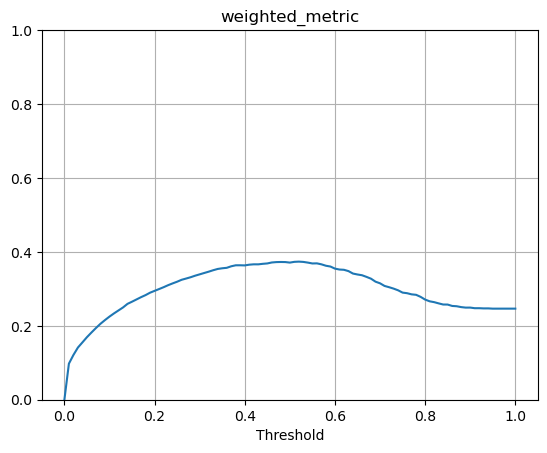

In [18]:
threshold_score['weighted_metric'].plot(grid=True, ylim=[0,1]).set_title('weighted_metric')

In [19]:
threshold_score.iloc[threshold_score['weighted_metric'].argmax()]

balanced_acc                       0.737008
true_pos_rate                      0.958117
true_neg_rate                      0.515899
miss_changes                     323.000000
miss_changed_ratio                 0.041883
miss_weighted_changes          15735.000000
miss_weighted_changed_ratio        0.028699
automatized_points             20895.000000
automatized_capacity               0.523999
raw_metric                         0.304534
weighted_metric                    0.373616
Name: 0.52, dtype: float64

In [22]:
thred = threshold_score.iloc[threshold_score['weighted_metric'].argmax()].name
print("The best threshold for the model is {:1.3f}.".format(thred))

0.1